# **MODELO FINAL PARA LA DETECCION DE CANCER DE MAMA**

##### **BIBLIOTECAS**

In [1]:
# Importar datos
import os
import zipfile
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import gcsfs
import joblib

# ML
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import NuSVC, SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    auc,
    classification_report,
    confusion_matrix,
    log_loss,
    make_scorer
)
#ENSEMBLE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

### **1. IMPORTAR IMAGENES, ETIQUETAS Y CARACTERISTICAS**

In [2]:
ruta_guardado = "gs://proyecto-363716-us-notebooks/imagenes_y_etiquetas_balanceadas4.pkl"
# Crear el sistema de archivos de GCS
fs = gcsfs.GCSFileSystem()
# Leer el archivo .pkl para imagenes y etiquetas
with fs.open(ruta_guardado, 'rb') as f:
    datos_cargados = pd.read_pickle(f)    

# Caracteristicas
etiqueta_guardado = "gs://proyecto-363716-us-notebooks/caracteristicas_reducidas.pkl"
with fs.open(etiqueta_guardado, "rb") as c:
    caracteristicas_reducidas = pd.read_pickle(c)
    
# Acceder a imagenes y etiquetas cargadas
imagenes = datos_cargados["imagenes"]
etiquetas = datos_cargados["etiquetas"]
print(caracteristicas_reducidas.shape)
print(etiquetas.shape)

(2500, 2043)
(2500,)


### **2. DIVISION DE DATOS (TRAIN, TEST, VAL)**

In [3]:
# Dividir datos
X = caracteristicas_reducidas
y = etiquetas
# PREPROCESAMIENTO DE DATOS
label = LabelEncoder()
y_label = label.fit_transform(y)
X_float = X.astype(np.float64)
#Dividir entrenamiento, test y val
X_train, X_temp, y_train, y_temp = train_test_split(X_float, y_label, test_size=0.3, random_state=42, stratify=y_label)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
# Usar np.unique para contar las ocurrencias de cada valor
values, counts = np.unique(etiquetas, return_counts=True)
valuess, countss = np.unique(y_train, return_counts=True)
valuesss, countsss = np.unique(y_temp, return_counts=True)
valuessss, countssss = np.unique(y_val, return_counts=True)

#Nomenclatura de BI-rads
print('====NUEVA NOMENCLATURA DE BI-RADS====')
print(np.unique(y_label))
print('BI-RADS_1 = 0',
'\nBI-RADS_2 = 1'
'\nBI-RADS_3 = 2'
'\nBI-RADS_4 = 3'
'\nBI-RADS_5 = 4')

print('\n\nDATOS TOTALES')
# Mostrar los valores y sus conteos
for value, count in zip(values, counts):
    print(f"Valor: {value}, Conteo: {count}")
print('\nDATOS ENTRENAMIENTO')
# Mostrar los valores y sus conteos
for value, count in zip(valuess, countss):
    print(f"Valor: {value}, Conteo: {count}")
print('\nDATOS TEMPO')
# Mostrar los valores y sus conteos
for value, count in zip(valuesss, countsss):
    print(f"Valor: {value}, Conteo: {count}")
print('\nDATOS VALIDACION Y TEST')
# Mostrar los valores y sus conteos
for value, count in zip(valuessss, countssss):
    print(f"Valor: {value}, Conteo: {count}")

====NUEVA NOMENCLATURA DE BI-RADS====
[0 1 2 3 4]
BI-RADS_1 = 0 
BI-RADS_2 = 1
BI-RADS_3 = 2
BI-RADS_4 = 3
BI-RADS_5 = 4


DATOS TOTALES
Valor: BI-RADS_1, Conteo: 500
Valor: BI-RADS_2, Conteo: 500
Valor: BI-RADS_3, Conteo: 500
Valor: BI-RADS_4, Conteo: 500
Valor: BI-RADS_5, Conteo: 500

DATOS ENTRENAMIENTO
Valor: 0, Conteo: 350
Valor: 1, Conteo: 350
Valor: 2, Conteo: 350
Valor: 3, Conteo: 350
Valor: 4, Conteo: 350

DATOS TEMPO
Valor: 0, Conteo: 150
Valor: 1, Conteo: 150
Valor: 2, Conteo: 150
Valor: 3, Conteo: 150
Valor: 4, Conteo: 150

DATOS VALIDACION Y TEST
Valor: 0, Conteo: 75
Valor: 1, Conteo: 75
Valor: 2, Conteo: 75
Valor: 3, Conteo: 75
Valor: 4, Conteo: 75


### **3. BUSQUEDA DE HIPERPARAMETROS, ENSEMBLE Y CONSTRUCCION DE MODELO**



##### *ENSEMBLE CON RANDOM FOREST*
Si aplico exclusivamente el modelo NuSVC tendre sobreajuste. Utilizaré Ensemble con randomforest para mejorar la capacidad de generalización.

In [4]:
# Definir el scoring para F1 y Log Loss
clases = np.unique(y_label) #Asegurar que todas las clases sean representadas
scoring = {
    'f1_weighted': 'f1_weighted',
    'log_loss': make_scorer(log_loss, greater_is_better=False, response_method='predict_proba', labels=clases)
}
# modelos
svc = SVC(random_state=42, probability=True)
nusvc = NuSVC(random_state=42, probability=True, class_weight=None, coef0=0, gamma='scale', kernel='poly', nu=0.1)
rf = RandomForestClassifier(random_state=42, max_depth= 10, min_samples_split=10, n_estimators=100)
# Crear VotingClassifier
ensemble_model = VotingClassifier(estimators=[('rf', rf), ('nusvc', nusvc), ('svc', svc)], voting='soft')
# Busqueda de hiperparametros
hiperparametros = {
    #svc
    "svc__C": [0.1, 1, 10],
    "svc__kernel": ["linear", "rbf"],
    "svc__gamma": ["scale", "auto"]
}
#Asegurarme que cada pliegue contenga ejemplos de todas las clases
clases_iguales = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# utilizar la busqueda de hiperparametros con validacion cruzada
grid = GridSearchCV(ensemble_model, hiperparametros, scoring=scoring, cv=clases_iguales, refit='f1_weighted', n_jobs=-1)

In [5]:
# Ejecutar
grid.fit(X_train, y_train)
modelo_optimizado = grid.best_estimator_
print("Mejores hiperparametros", grid.best_params_)

Mejores hiperparametros {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


### **4. VISUALIZACION DE METRICAS DE EVALUACION**

METRICAS DE EVALUACION MODELO:
----------------------------------

Reporte de clasificacion test
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        75
           1       0.99      0.99      0.99        75
           2       1.00      0.99      0.99        75
           3       0.99      0.97      0.98        75
           4       1.00      1.00      1.00        75

    accuracy                           0.99       375
   macro avg       0.99      0.99      0.99       375
weighted avg       0.99      0.99      0.99       375



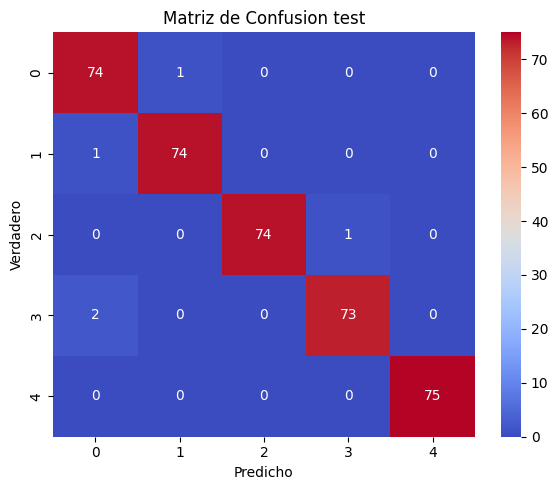

In [6]:
# Predicciones
y_pred = modelo_optimizado.predict(X_test)
reporte = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
# Reporte de clasificacion
print("METRICAS DE EVALUACION MODELO:")
print("----------------------------------\n")
print("Reporte de clasificacion test")
print(reporte)
# -------------------------------------------------------------------------------
# Matriz de confusion
plt.figure(figsize=(6, 5), dpi=100)
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt="d")
plt.title("Matriz de Confusion test")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.savefig("Matriz_modelo_test.png")
plt.tight_layout()
plt.show()

METRICAS DE EVALUACION MODELO:
----------------------------------

Reporte de clasificacion val
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        75
           1       0.93      0.95      0.94        75
           2       0.97      1.00      0.99        75
           3       0.97      0.99      0.98        75
           4       0.99      0.99      0.99        75

    accuracy                           0.96       375
   macro avg       0.96      0.96      0.96       375
weighted avg       0.96      0.96      0.96       375



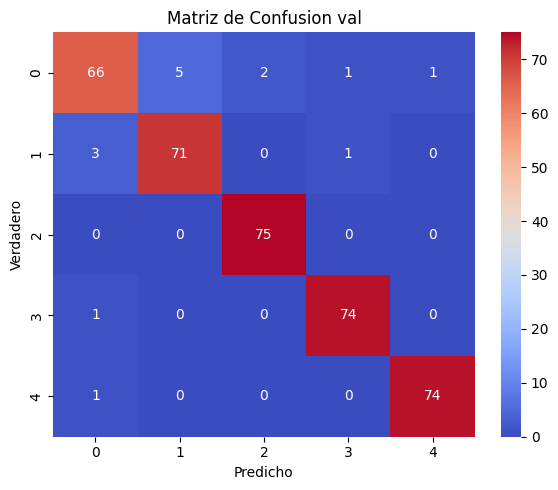

In [7]:
# Predicciones
y_pred = modelo_optimizado.predict(X_val)
reporte = classification_report(y_val, y_pred)
matrix = confusion_matrix(y_val, y_pred)
# Reporte de clasificacion
print("METRICAS DE EVALUACION MODELO:")
print("----------------------------------\n")
print("Reporte de clasificacion val")
print(reporte)
# -------------------------------------------------------------------------------
# Matriz de confusion
plt.figure(figsize=(6, 5), dpi=100)
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt="d")
plt.title("Matriz de Confusion val")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.savefig("Matriz_modelo_val.png")
plt.tight_layout()
plt.show()

METRICAS DE EVALUACION MODELO:
----------------------------------

Reporte de clasificacion temp
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       150
           1       0.96      0.97      0.96       150
           2       0.99      0.99      0.99       150
           3       0.98      0.98      0.98       150
           4       0.99      0.99      0.99       150

    accuracy                           0.97       750
   macro avg       0.97      0.97      0.97       750
weighted avg       0.97      0.97      0.97       750



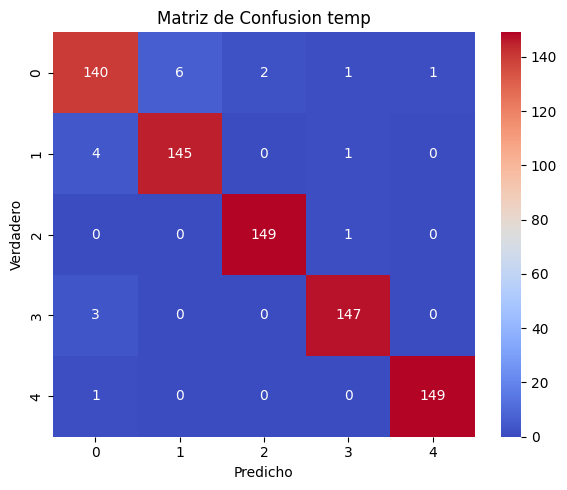

In [8]:
# Predicciones
y_pred = modelo_optimizado.predict(X_temp)
reporte = classification_report(y_temp, y_pred)
matrix = confusion_matrix(y_temp, y_pred)
# Reporte de clasificacion
print("METRICAS DE EVALUACION MODELO:")
print("----------------------------------\n")
print("Reporte de clasificacion temp")
print(reporte)
# -------------------------------------------------------------------------------
# Matriz de confusion
plt.figure(figsize=(6, 5), dpi=100)
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt="d")
plt.title("Matriz de Confusion temp")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.savefig("Matriz_modelo_temp.png")
plt.tight_layout()
plt.show()

### **5. VISUALIZACION DE SOBREAJUSTE**

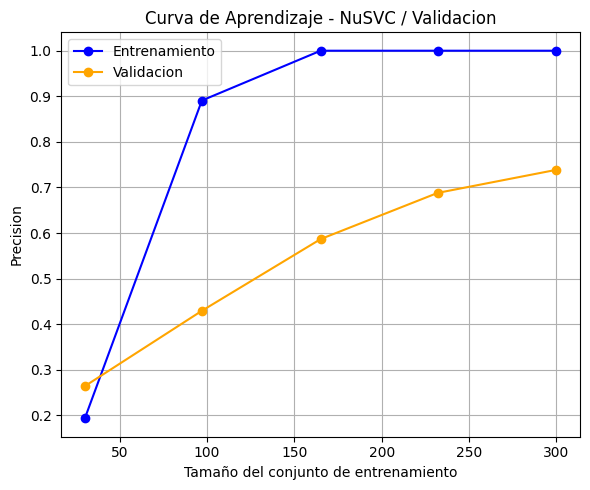

Tamaño conjunto de datos de entrenamiento: [ 30  97 165 232 300]

CURVA DE APRENDIZAJE DE ENTRENAMIENTO:
[[0.96666667 0.         0.         0.         0.        ]
 [0.94845361 1.         0.83505155 0.83505155 0.83505155]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]]
Promedios: [0.19333333 0.89072165 1.         1.         1.        ]

CURVA DE APRENDIZAJE DE VALIDACION:
[[0.34666667 0.32       0.17333333 0.2        0.28      ]
 [0.46666667 0.46666667 0.37333333 0.37333333 0.46666667]
 [0.58666667 0.57333333 0.54666667 0.62666667 0.6       ]
 [0.65333333 0.72       0.64       0.73333333 0.69333333]
 [0.70666667 0.82666667 0.66666667 0.77333333 0.72      ]]
Promedios: [0.264      0.42933333 0.58666667 0.688      0.73866667]


In [14]:
#=======EVALUACION SOBREAJUSTE=======
# Curvas de aprendizaje
#learning_curve utiliza valdiacion cruzada, coge un fragmento de los 5 de X_train para evaluar y asi en cada uno
train_sizes_val, train_scores, test_scores = learning_curve(modelo_optimizado, X_val, y_val, cv=5, scoring="accuracy")
# Calcular medias y desviacion estandar
train_prom = np.mean(train_scores, axis=1)
test_prom = np.mean(test_scores, axis=1)

# Grafica las curvas de aprendizaje
plt.figure(figsize=(6, 5), dpi=100)
plt.plot(train_sizes_val, train_prom, label="Entrenamiento", marker='o', color='blue')
plt.plot(train_sizes_val, test_prom, label="Validacion", marker='o',color='orange')
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precision")
plt.title("Curva de Aprendizaje - NuSVC / Validacion")
plt.grid()
plt.legend(loc="best")
plt.tight_layout()
#plt.savefig('curva_aprendizaje_val')
plt.show()

#================================================================
print('Tamaño conjunto de datos de entrenamiento:', train_sizes_val)
print('\nCURVA DE APRENDIZAJE DE ENTRENAMIENTO:')
print(train_scores)
print('Promedios:', train_prom)
print('\nCURVA DE APRENDIZAJE DE VALIDACION:')
print(test_scores)
print('Promedios:', test_prom)

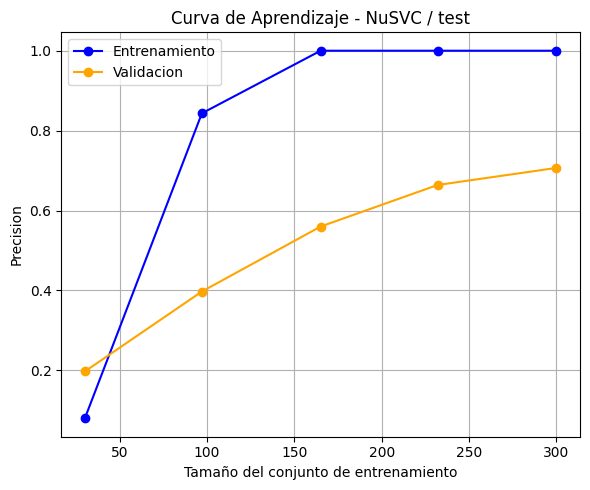

Tamaño conjunto de datos de entrenamiento: [ 30  97 165 232 300]

CURVA DE APRENDIZAJE DE ENTRENAMIENTO:
[[0.4        0.         0.         0.         0.        ]
 [1.         0.86597938 0.78350515 0.78350515 0.78350515]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]]
Promedios: [0.08       0.84329897 1.         1.         1.        ]

CURVA DE APRENDIZAJE DE VALIDACION:
[[0.2        0.2        0.2        0.18666667 0.2       ]
 [0.38666667 0.44       0.4        0.46666667 0.29333333]
 [0.54666667 0.53333333 0.49333333 0.70666667 0.52      ]
 [0.65333333 0.65333333 0.53333333 0.77333333 0.70666667]
 [0.72       0.72       0.57333333 0.81333333 0.70666667]]
Promedios: [0.19733333 0.39733333 0.56       0.664      0.70666667]


In [18]:
#=======EVALUACION SOBREAJUSTE=======
# Curvas de aprendizaje
#learning_curve utiliza valdiacion cruzada, coge un fragmento de los 5 de X_train para evaluar y asi en cada uno
train_sizes_test, train_scores, test_scores = learning_curve(modelo_optimizado, X_test, y_test, cv=5, scoring="accuracy")
# Calcular medias y desviacion estandar
train_prom = np.mean(train_scores, axis=1)
test_prom = np.mean(test_scores, axis=1)

# Grafica las curvas de aprendizaje
plt.figure(figsize=(6, 5), dpi=100)
plt.plot(train_sizes_test, train_prom, label="Entrenamiento", marker='o', color='blue')
plt.plot(train_sizes_test, test_prom, label="Validacion", marker='o',color='orange')
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precision")
plt.title("Curva de Aprendizaje - NuSVC / test")
plt.grid()
plt.legend(loc="best")
plt.tight_layout()
#plt.savefig('curva_aprendizaje_test')
plt.show()

#================================================================
print('Tamaño conjunto de datos de entrenamiento:', train_sizes_test)
print('\nCURVA DE APRENDIZAJE DE ENTRENAMIENTO:')
print(train_scores)
print('Promedios:', train_prom)
print('\nCURVA DE APRENDIZAJE DE VALIDACION:')
print(test_scores)
print('Promedios:', test_prom)

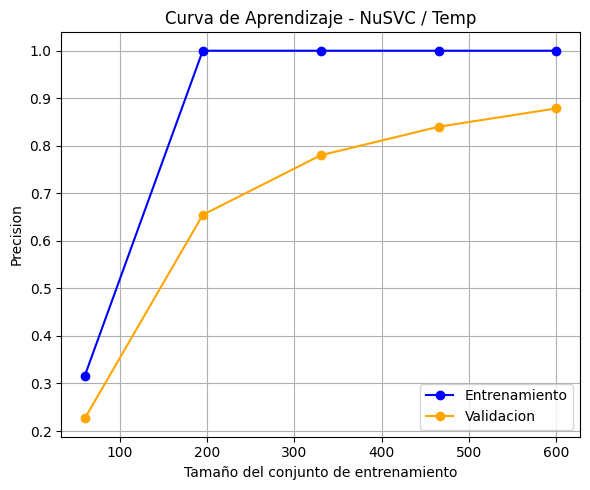

Tamaño conjunto de datos de entrenamiento: [ 60 195 330 465 600]

CURVA DE APRENDIZAJE DE ENTRENAMIENTO:
[[0.91666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]]
Promedios: [0.31666667 1.         1.         1.         1.        ]

CURVA DE APRENDIZAJE DE VALIDACION:
[[0.27333333 0.20666667 0.20666667 0.21333333 0.23333333]
 [0.62       0.58       0.67333333 0.68       0.72      ]
 [0.78       0.72       0.78666667 0.78       0.83333333]
 [0.82       0.78       0.86       0.83333333 0.90666667]
 [0.86666667 0.83333333 0.88       0.89333333 0.92      ]]
Promedios: [0.22666667 0.65466667 0.78       0.84       0.87866667]


In [11]:
#=======EVALUACION SOBREAJUSTE=======
# Curvas de aprendizaje
#learning_curve utiliza valdiacion cruzada, coge un fragmento de los 5 de X_train para evaluar y asi en cada uno
train_sizes, train_scores, test_scores = learning_curve(modelo_optimizado, X_temp, y_temp, cv=5, scoring="accuracy")
# Calcular medias y desviacion estandar
train_prom = np.mean(train_scores, axis=1)
test_prom = np.mean(test_scores, axis=1)

# Grafica las curvas de aprendizaje
plt.figure(figsize=(6, 5), dpi=100)
plt.plot(train_sizes, train_prom, label="Entrenamiento", marker='o', color='blue')
plt.plot(train_sizes, test_prom, label="Validacion", marker='o',color='orange')
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precision")
plt.title("Curva de Aprendizaje - NuSVC / Temp")
plt.grid()
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('curva_aprendizaje_temp')
plt.show()

#================================================================
print('Tamaño conjunto de datos de entrenamiento:', train_sizes)
print('\nCURVA DE APRENDIZAJE DE ENTRENAMIENTO:')
print(train_scores)
print('Promedios:', train_prom)
print('\nCURVA DE APRENDIZAJE DE VALIDACION:')
print(test_scores)
print('Promedios:', test_prom)

**Curvas de aprendizaje**

    Con validación (75 imágenes): obtengo resultados de entrenamiento del 100% y de validación del 74%.
    Con test (75 imágenes): obtengo resultados de entrenamiento del 100% y de prueba del 71%.
    Con temp (150 imágenes): obtengo resultados de entrenamiento del 100% y de temp del 88%.
Para evaluar el sobreajuste en cada curva de aprendizaje, utilicé tres fragmentos de datos. Observé que, a medida que aumenta la cantidad de datos utilizados, los porcentajes de validación, prueba (test) y temp mejoran, acercándose cada vez más al rendimiento en entrenamiento.

Por último, al comparar los resultados finales, noto que el dataset con mayor cantidad de datos es el más cercano a los resultados del entrenamiento. Esto indica que mi modelo generaliza mejor cuando se utiliza un mayor número de datos.

### **6. VISUALIZACION DE PERDIDA**

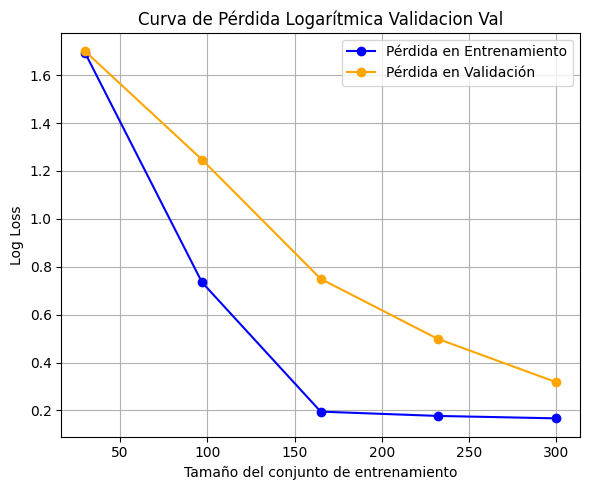

Tamaño conjunto de datos de entrenamiento: [ 30  97 165 232 300]

CURVA DE APRENDIZAJE DE ENTRENAMIENTO:
[1.6937394712719174, 0.7349629130745837, 0.19491028173295122, 0.17698438558960855, 0.16679297479556549]

CURVA DE APRENDIZAJE DE VALIDACION:
[1.6999750536432232, 1.2474683794206964, 0.7492084940550225, 0.4988076855286228, 0.3174925930997478]


In [16]:
# =======EVALUACION PERDIDA=======
# Calcular probabilidades predichas
train_loss_lista = []
test_loss_lista = []

for tamaño in train_sizes_val:
    X_tamaño = X_val[:tamaño]
    y_tamaño = y_val[:tamaño]
    #entrenar con datos reducidos
    modelo_optimizado.fit(X_tamaño, y_tamaño)
    #Calcular probabilidades predichas
    y_train_prob = modelo_optimizado.predict_proba(X_tamaño)
    y_val_prob = modelo_optimizado.predict_proba(X_val)
    #calcular perdida (logg)
    train_loss = log_loss(y_tamaño, y_train_prob)
    val_loss = log_loss(y_val, y_val_prob)
    
    train_loss_lista.append(train_loss)
    test_loss_lista.append(val_loss)

# ====== Graficar las curvas de Log Loss ======
plt.figure(figsize=(6, 5), dpi=100)
plt.plot(train_sizes_val, train_loss_lista, label="Pérdida en Entrenamiento", color="blue", marker='o')
plt.plot(train_sizes_val, test_loss_lista, label="Pérdida en Validación", color="orange", marker='o')
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Log Loss")
plt.title("Curva de Pérdida Logarítmica Validacion Val")
plt.grid()
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('loss_log_val')
plt.show()

#================================================================
print('Tamaño conjunto de datos de entrenamiento:', train_sizes_val)
print('\nCURVA DE APRENDIZAJE DE ENTRENAMIENTO:')
print(train_loss_lista)
print('\nCURVA DE APRENDIZAJE DE VALIDACION:')
print(test_loss_lista)

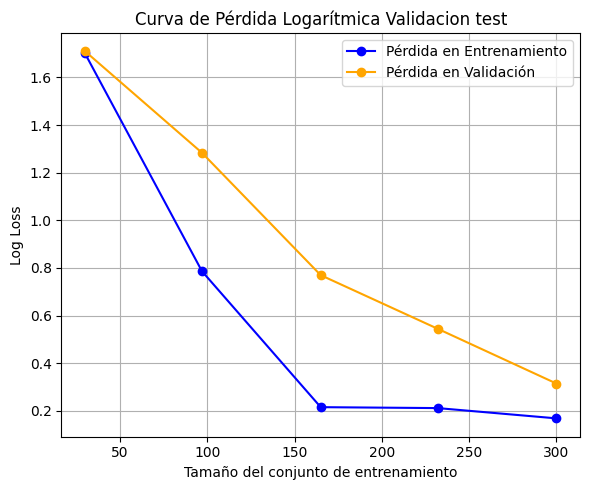

Tamaño conjunto de datos de entrenamiento: [ 30  97 165 232 300]

CURVA DE APRENDIZAJE DE ENTRENAMIENTO:
[1.7007321622119422, 0.7863270811202374, 0.21553165595675444, 0.21166070763650027, 0.16851265389399936]

CURVA DE APRENDIZAJE DE VALIDACION:
[1.710038231131813, 1.2834641740022643, 0.7697479440166103, 0.5446496183544562, 0.3146820730867339]


In [19]:
# =======EVALUACION PERDIDA=======
# Calcular probabilidades predichas
train_loss_lista = []
test_loss_lista = []

for tamaño in train_sizes_test: 
    X_tamaño = X_test[:tamaño]
    y_tamaño = y_test[:tamaño]
    #entrenar con datos reducidos
    modelo_optimizado.fit(X_tamaño, y_tamaño)
    #Calcular probabilidades predichas
    y_train_prob = modelo_optimizado.predict_proba(X_tamaño)
    y_val_prob = modelo_optimizado.predict_proba(X_test)
    #calcular perdida (logg)
    train_loss = log_loss(y_tamaño, y_train_prob)
    val_loss = log_loss(y_test, y_val_prob)
    
    train_loss_lista.append(train_loss)
    test_loss_lista.append(val_loss)

# ====== Graficar las curvas de Log Loss ======
plt.figure(figsize=(6, 5), dpi=100)
plt.plot(train_sizes_test, train_loss_lista, label="Pérdida en Entrenamiento", color="blue", marker='o')
plt.plot(train_sizes_test, test_loss_lista, label="Pérdida en Validación", color="orange", marker='o')
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Log Loss")
plt.title("Curva de Pérdida Logarítmica Validacion test")
plt.grid()
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('log_loss_test')
plt.show()

#================================================================
print('Tamaño conjunto de datos de entrenamiento:', train_sizes_test)
print('\nCURVA DE APRENDIZAJE DE ENTRENAMIENTO:')
print(train_loss_lista)
print('\nCURVA DE APRENDIZAJE DE VALIDACION:')
print(test_loss_lista)


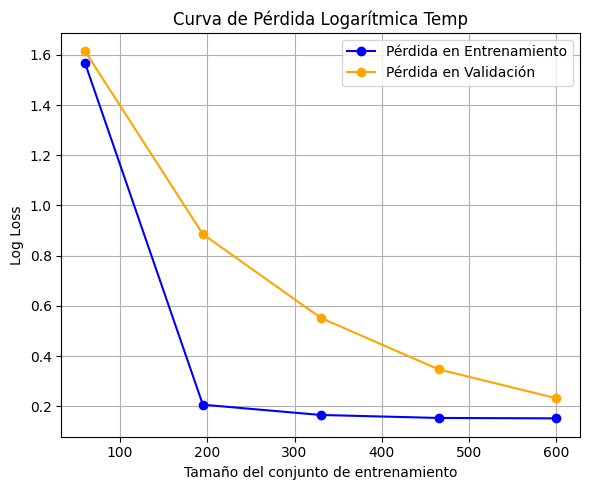

Tamaño conjunto de datos de entrenamiento: [ 60 195 330 465 600]

CURVA DE APRENDIZAJE DE ENTRENAMIENTO:
[1.5684059325240838, 0.20590552412022836, 0.16495350178573123, 0.1530601777574224, 0.15140471874265052]

CURVA DE APRENDIZAJE DE VALIDACION:
[1.6150994167998909, 0.8857398051585084, 0.5521531927860149, 0.34677078507226117, 0.23159366477484533]


In [20]:
# =======EVALUACION PERDIDA=======
# Calcular probabilidades predichas
train_loss_lista = []
test_loss_lista = []

for tamaño in train_sizes:
    X_tamaño = X_temp[:tamaño]
    y_tamaño = y_temp[:tamaño]
    #entrenar con datos reducidos
    modelo_optimizado.fit(X_tamaño, y_tamaño)
    #Calcular probabilidades predichas
    y_train_prob = modelo_optimizado.predict_proba(X_tamaño)
    y_temp_prob = modelo_optimizado.predict_proba(X_temp)
    #calcular perdida (logg)
    train_loss = log_loss(y_tamaño, y_train_prob)
    temp_loss = log_loss(y_temp, y_temp_prob)
    
    train_loss_lista.append(train_loss)
    test_loss_lista.append(temp_loss)

# ====== Graficar las curvas de Log Loss ======
plt.figure(figsize=(6, 5), dpi=100)
plt.plot(train_sizes, train_loss_lista, label="Pérdida en Entrenamiento", color="blue", marker='o')
plt.plot(train_sizes, test_loss_lista, label="Pérdida en Validación", color="orange", marker='o')
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Log Loss")
plt.title("Curva de Pérdida Logarítmica Temp")
plt.grid()
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('log_loss_temp')
plt.show()

#================================================================
print('Tamaño conjunto de datos de entrenamiento:', train_sizes)
print('\nCURVA DE APRENDIZAJE DE ENTRENAMIENTO:')
print(train_loss_lista)
print('\nCURVA DE APRENDIZAJE DE VALIDACION:')
print(test_loss_lista)

### **7. GUARDAR MODELO**

In [12]:
# Ejecutar
grid.fit(X_float, y_label)
modelo_optimizado_cancer_mama = grid.best_estimator_
# GUARDAR MODELO
joblib.dump(modelo_optimizado_cancer_mama,'m_cancer_mama.joblib')


['m_cancer_mama.joblib']